In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

# Importing the modules themselves for reloading
import trading_bot.TradePosition
import trading_bot.TouchArea
import trading_bot.TradingStrategy
import trading_bot.TouchDetection
import trading_bot.TouchDetectionParameters
import trading_bot.MultiSymbolDataRetrieval
import trading_bot.TypedBarData

# Reloading the modules to apply any changes
import importlib
importlib.reload(trading_bot.TradePosition)
importlib.reload(trading_bot.TouchArea)
importlib.reload(trading_bot.TradingStrategy)
importlib.reload(trading_bot.TouchDetection)
importlib.reload(trading_bot.TouchDetectionParameters)
importlib.reload(trading_bot.MultiSymbolDataRetrieval)
importlib.reload(trading_bot.TypedBarData)

from trading_bot.TradePosition import TradePosition, csv_to_trade_positions, plot_cumulative_pl_and_price
from trading_bot.TouchArea import TouchArea
from trading_bot.TradingStrategy import StrategyParameters, TouchDetectionAreas, TradingStrategy 

from trading_bot.TouchDetection import calculate_touch_detection_area, plot_touch_detection_areas
from trading_bot.TouchDetectionParameters import BacktestTouchDetectionParameters, np_median, np_mean, get_latest_value
from trading_bot.MultiSymbolDataRetrieval import fill_missing_data

In [2]:
# symbol = "NVDA" # good
# symbol = "MSFT" # bad
# symbol = "META" # bad
# symbol = "AAPL" # mid
# symbol = "TJX"
# symbol = "JNJ"
# symbol = "AMZN" # mid
# symbol = "AZN"
# symbol = "TSLA" # good
# symbol = "TJX"
# symbol = "GOOGL" # mid

# symbol = 'MSTR' # bad
symbol = 'MARA' # good
# symbol = 'INTC' # bad
# symbol = 'GOOG' # bad


start_date = "2022-01-12 00:00:00"
end_date =   "2022-01-13 00:00:00"

# start_date = "2022-01-01 00:00:00"
# end_date =   "2022-02-01 00:00:00"

start_date = "2024-01-01 00:00:00"
# end_date =   "2024-08-17 00:00:00"
end_date =   "2024-09-27 00:00:00"

# start_date = "2017-01-01 00:00:00"
# end_date =   "2018-01-01 00:00:00"

# start_date = "2024-07-01 00:00:00"
# end_date =   "2024-08-01 00:00:00"

# start_date = "2024-08-01 00:00:00"
# end_date =   "2024-09-01 00:00:00"

# start_date = "2024-09-01 00:00:00"
# end_date =   "2024-10-01 00:00:00"

# start_date = "2024-10-01 00:00:00"
# end_date =   "2024-11-01 00:00:00"

start_date = "2024-11-01 00:00:00"
end_date =   "2024-12-01 00:00:00"

# start_date = "2024-09-04 00:00:00"
# end_date =   "2024-09-05 00:00:00"

# start_date = "2024-11-22 00:00:00"
# end_date =   "2024-11-23 00:00:00"

# Usage example:
touch_detection_params = BacktestTouchDetectionParameters(
    symbol=symbol,
    start_date=start_date,
    end_date=end_date,
    atr_period=15,
    level1_period=15,
    # multiplier=1.4,
    min_touches=3,
    start_time=None,
    end_time='15:55',
    # end_time='11:20',
    # use_median=True,
    # touch_area_width_agg=get_latest_value,
    
    ema_span=12,
    price_ema_span=26,
    
    export_bars_path=f'bars/bars_{symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv',
    export_quotes_path=f'quotes/quotes_{symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
)

touch_detection_areas = calculate_touch_detection_area(touch_detection_params)

# touch_detection_areas = calculate_touch_detection_area(symbol, start_date, end_date, atr_period=15, level1_period=15, multiplier=1.4, min_touches=3, start_time=None, end_time='15:55', \
#     use_median=True, touch_area_width_agg=np_median,  export_bars_path=f'bars_{symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv')


2024-12-13 18:17:14,484 - MultiSymbolDataRetrieval - INFO - Retrieved bars_MARA_2024-11-01_2024-12-01.csv from bars\bars_MARA_2024-11-01_2024-12-01.zip
2024-12-13 18:17:14,644 - MultiSymbolDataRetrieval - INFO - Retrieved bars_MARA_2024-11-01_2024-12-01_unadjusted.csv from bars\bars_MARA_2024-11-01_2024-12-01.zip
2024-12-13 18:17:31,464 - MultiSymbolDataRetrieval - INFO - Retrieved quotes for MARA from quotes\quotes_MARA_2024-11-01_2024-12-01.zip


In [3]:
# temp = touch_detection_areas.quotes.reset_index()
# temp['minute'] = temp.timestamp.apply(lambda x: pd.Timestamp(x).replace(second=0, microsecond=0))
# temp.groupby('minute').count()['symbol'].describe()

In [4]:
# temp.groupby('minute').count()['symbol']

In [5]:
def calculate_sorted_quote_changes(df):
    """
    Calculate and sort quote changes for each minute.
    
    :param df: DataFrame with (symbol, timestamp) multi-index and bid_price, ask_price columns
    :return: DataFrame with sorted quote changes
    """
    # Reset the index to make timestamp a column
    df = df.reset_index()

    # Convert timestamp to datetime if it's not already
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Create a minute column
    df['minute'] = df['timestamp'].dt.floor('min')

    # Group by symbol and minute, then calculate the changes
    grouped = df.groupby(['symbol', 'minute'])
    changes = grouped.apply(lambda x: pd.Series({
        'bid_change': x['bid_price'].diff().iloc[-1] if len(x) > 1 else 0,
        'ask_change': x['ask_price'].diff().iloc[-1] if len(x) > 1 else 0,
        'timestamp': x['timestamp'].iloc[0]  # Keep the timestamp of the first quote in the minute
    }))

    # Reset the index to make symbol and minute columns
    changes = changes.reset_index()

    # Sort by bid_change and ask_change in descending order
    changes_sorted = changes.sort_values(['bid_change', 'ask_change'], ascending=[False, False])

    return changes_sorted

# Example usage:
# sorted_changes = calculate_sorted_quote_changes(touch_detection_areas.quotes)
# sorted_changes

In [6]:
# times = touch_detection_areas.bars.index.get_level_values('timestamp').time
# print(touch_detection_areas.bars.loc[(times >= time(9,30)) & (times <= time(16,0))])

In [7]:
# print(touch_detection_areas.quotes_raw)

In [8]:
# print(touch_detection_areas.quotes_agg)

In [9]:

def plot_quote_changes_histogram(sorted_changes, num_bins=50):
    """
    Create histograms of bid and ask price changes.
    
    :param sorted_changes: DataFrame returned by calculate_sorted_quote_changes function
    :param num_bins: Number of bins for the histogram (default: 50)
    """
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    # Plot histogram of bid changes
    ax1.hist(sorted_changes['bid_change'], bins=num_bins, edgecolor='black')
    ax1.set_title('Histogram of Bid Price Changes')
    ax1.set_xlabel('Bid Price Change')
    ax1.set_ylabel('Frequency')
    
    # Plot histogram of ask changes
    ax2.hist(sorted_changes['ask_change'], bins=num_bins, edgecolor='black')
    ax2.set_title('Histogram of Ask Price Changes')
    ax2.set_xlabel('Ask Price Change')
    ax2.set_ylabel('Frequency')
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()
# plot_quote_changes_histogram(sorted_changes)

In [10]:
# sorted_changes.describe()

In [11]:
# (touch_detection_areas.bars[touch_detection_areas.mask]['avg_volume_2'] == touch_detection_areas.bars[touch_detection_areas.mask]['avg_volume_3']).value_counts()

In [12]:
touch_detection_areas.bars[touch_detection_areas.mask][['volume']+[a for a in touch_detection_areas.bars.columns if a.startswith('avg_volume')]]

volume     avg_volume
symbol timestamp                                          
MARA   2024-11-01 09:30:00-04:00     1824.0    6125.322778
       2024-11-01 09:31:00-04:00   339843.0   57466.503889
       2024-11-01 09:32:00-04:00   213288.0   81439.041752
       2024-11-01 09:33:00-04:00   154897.0   92740.266098
       2024-11-01 09:34:00-04:00   167712.0  104274.379006
...                                     ...            ...
       2024-11-29 12:53:00-05:00   698103.0  482968.020216
       2024-11-29 12:54:00-05:00   435126.0  475607.709414
       2024-11-29 12:55:00-05:00   573103.0  490606.984889
       2024-11-29 12:56:00-05:00  1037301.0  574713.756444
       2024-11-29 12:57:00-05:00   318641.0  535317.947760

[7542 rows x 2 columns]

In [13]:
print(touch_detection_areas.bars[touch_detection_areas.mask].columns.to_list())

['open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap', 'MACD', 'MACD_signal', 'MACD_hist', 'MACD_hist_roc', 'RSI', 'RSI_roc', 'MFI', 'MFI_roc', 'central_value', 'is_res', 'H_L', 'ATR', 'MTR', 'avg_volume', 'avg_trade_count', 'log_return', 'volatility', 'rolling_range_min_4', 'rolling_range_min_7', 'rolling_ATR']


In [14]:
# touch_detection_areas.bars[touch_detection_areas.mask].reset_index().to_csv('asdf2.csv',index=False)
# touch_detection_areas.bars.reset_index().to_csv('asdfasdf.csv',index=False)

In [15]:
# a = touch_detection_areas.bars[touch_detection_areas.mask]['trade_count'].astype(float).describe()
# b = touch_detection_areas.bars[touch_detection_areas.mask]['volume'].astype(float).describe()
# c = touch_detection_areas.bars[touch_detection_areas.mask]['shares_per_trade'].astype(float).describe()
# pd.concat([a,b,c],axis=1)

In [16]:
# # zoom_start_date = start_date
# # zoom_end_date = end_date
# zoom_start_date = "2024-08-20 13:30:00"
# zoom_end_date =   "2024-08-20 13:40:00"
# plot_touch_detection_areas(touch_detection_areas)
# plot_touch_detection_areas(touch_detection_areas, zoom_start_date, zoom_end_date)

In [17]:
len(touch_detection_areas.long_touch_area) + len(touch_detection_areas.short_touch_area)

4241

In [18]:
# print(touch_detection_areas.rsi_overbought)
# print(touch_detection_areas.rsi_oversold)

MARA is marginable.
MARA is shortable and ETB.
END
Strategy: Long&Short
MARA is marginable.
MARA is shortable and ETB.
2024-11-01 09:30:00-04:00 -> 2024-11-29 12:57:00-05:00

Overall Statistics:
Initial Investment: 30000
Final Balance:      64413.2513
Balance % change:   114.7108% ***
Baseline % change:  61.4435%
Number of Trades Executed: 364
Simultaneous close and open count: 97

Total Profit/Loss (after fees): $34413.2513
  Total Profit: $37509.4020
  Total Loss:   $-3096.1507
Total Transaction Costs: $1044.1168
  Borrow Fees: $0.1910
  Commission: $948.7280

Average Profit/Loss per Trade (after fees): $94.5419

Detailed Trade Statistics:
Statistic       count    mean     std     min     25%     50%     75%      max
Trade Category                                                                
All               364  0.9776  2.9001 -1.2225 -0.1294 -0.0215  0.5640  23.7072
Win               138  2.8432  4.0700  0.0247  0.3376  1.1901  3.2912  23.7072
Lose              226 -0.1616  0.2

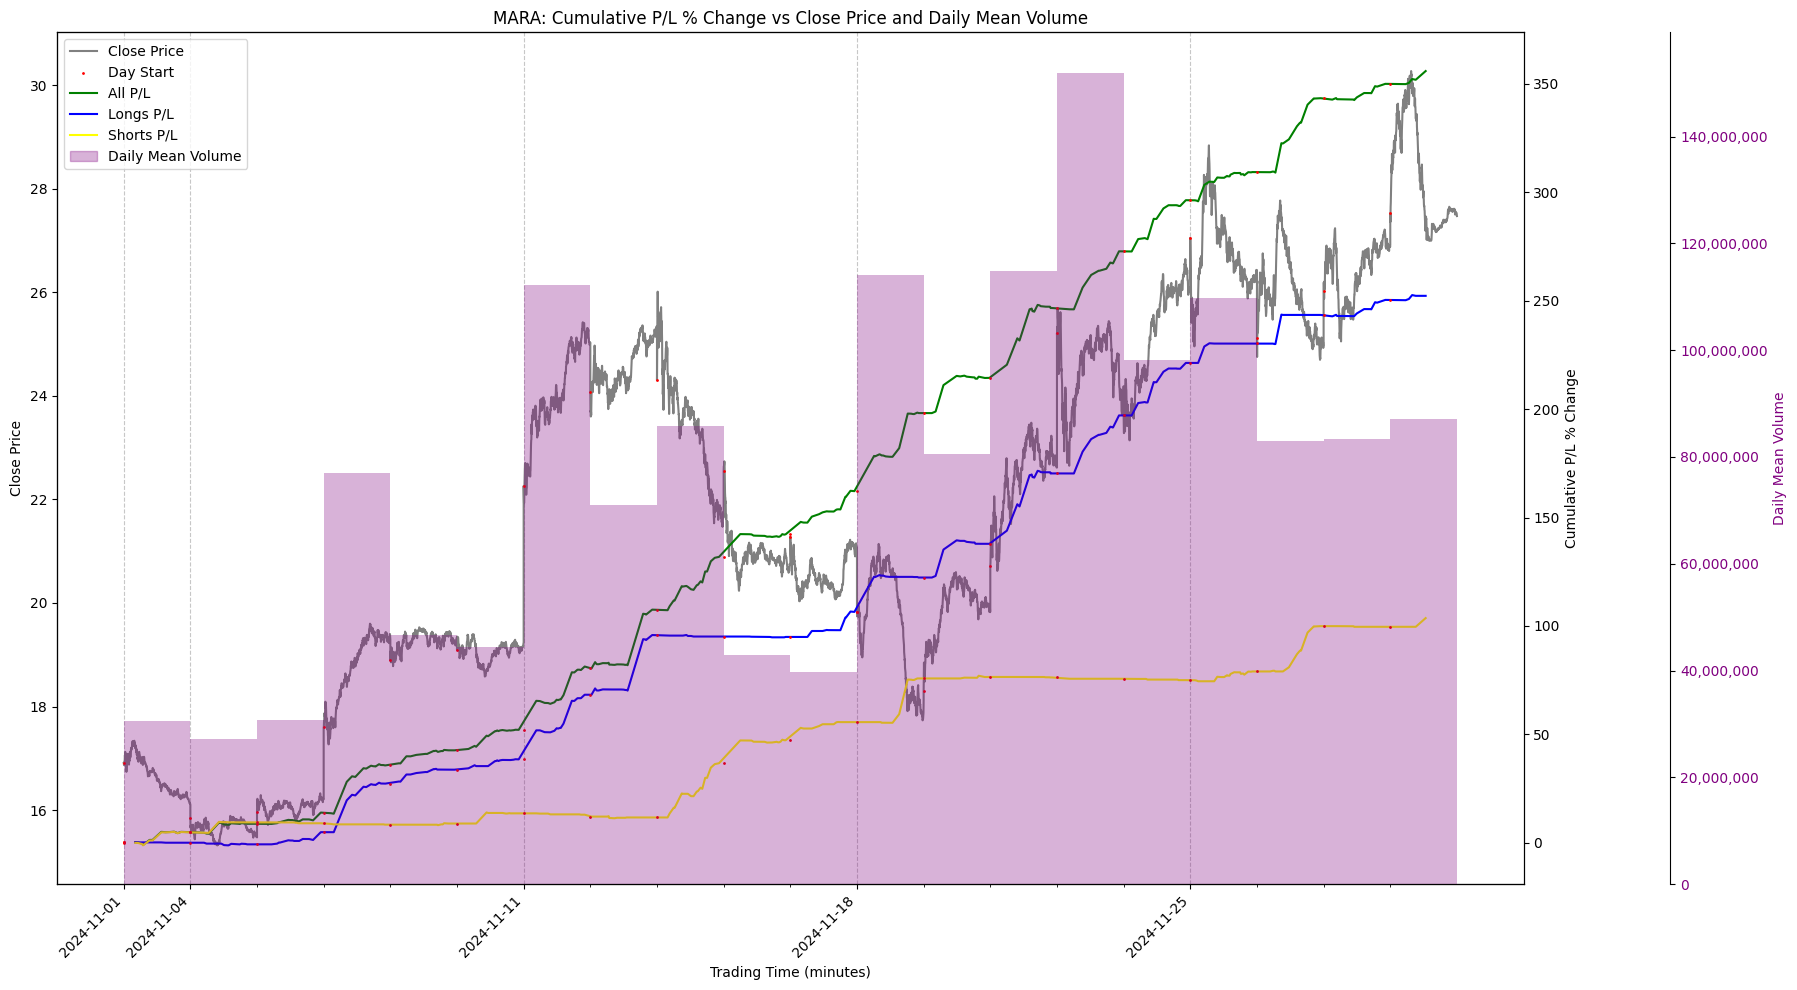

In [19]:
import trading_bot.TouchArea
import trading_bot.TradingStrategy
import trading_bot.TradingStrategyParameters
import trading_bot.TouchDetection
import trading_bot.TradePosition
import trading_bot.TypedBarData

import importlib
importlib.reload(trading_bot.TradingStrategy)
importlib.reload(trading_bot.TradingStrategyParameters)
importlib.reload(trading_bot.TouchDetection)
importlib.reload(trading_bot.TradePosition)
importlib.reload(trading_bot.TouchArea)
importlib.reload(trading_bot.TypedBarData)

from trading_bot.TradingStrategy import StrategyParameters, TouchDetectionAreas, TradingStrategy 
from trading_bot.TouchDetection import *



strategy_params = StrategyParameters(
    initial_investment=30_000,
    max_investment=30_000,

    do_longs=True,
    do_shorts=True,
    sim_longs=True,
    sim_shorts=True,
    
    use_margin=True,
    
    assume_marginable_and_etb=True,
    
    times_buying_power=1,
    
    soft_start_time = None, 
    soft_end_time = '15:30',
    
    # plot_day_results=True,
    
    # allow_reversal_detection=True, # False (no switching) seems better for more stocks. If True, clear_passed_areas=True might improve performance.
    
    # clear_passed_areas=True # False is better for meme stocks, True better for mid and losing stocks (reduces losses).
    
    # min_stop_dist_relative_change_for_partial=1,
    
)

# strategy_params.slippage.slippage_factor=1  # default is 0.02
strategy_params.gradual_entry_range_multiplier = 0.9
strategy_params.ordersizing.max_volume_percentage = 0.2 # %. default is 1 %


strategy = TradingStrategy(touch_detection_areas, strategy_params, export_trades_path=f'trades_output_{symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv')
# strategy = TradingStrategy(touch_detection_areas, strategy_params, export_trades_path=f'trades_output_{symbol} get_latest_value 1.725.csv')
results = strategy.run_backtest()

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import spearmanr
import statsmodels.api as sm

def get_original_type(row):
    """
    If type starts with *, return the opposite of what follows.
    Otherwise return the type as is.
    """
    if row['Type'].startswith('*'):
        # Return opposite of what follows the *
        return 'Short' if row['Type'].endswith('Long') else 'Long'
    return row['Type']

def analyze_trading_performance(df):
    # Add indicator for switched areas
    df['Switched'] = df['Type'].str.startswith('*')
    df['Original_Type'] = df.apply(get_original_type, axis=1)
    
    # Create figure with multiple subplots
    plt.style.use('seaborn-v0_8-whitegrid')
    fig = plt.figure(figsize=(20, 12))
    
    # 1. Correlation Analysis
    indicators = ['RSI', 'RSI_roc', 'MACD', 'MACD_hist', 'MACD_hist_roc', 'shares_per_trade', 'doji_ratio', 'wick_ratio', 'nr4_hl_diff','nr7_hl_diff','volume_ratio','ATR_ratio']
    performance_metrics = ['Total P/L', 'ROE (P/L %)']
    
    # Calculate correlation matrix
    corr_matrix = df[indicators + performance_metrics].corr()
    
    # Plot correlation heatmap
    plt.subplot(2, 3, 1)
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap')
    
    # 2. Scatter plots with regression lines for RSI vs Performance
    plt.subplot(2, 3, 2)
    sns.scatterplot(data=df, x='RSI', y='ROE (P/L %)', 
                    hue='Original_Type', style='Switched',
                    palette={'Long': 'green', 'Short': 'red'})
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(x=30, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(x=70, color='gray', linestyle='--', alpha=0.5)
    plt.title('RSI vs ROE by Trade Type')
    
    # 3. Box plots for performance comparison
    plt.subplot(2, 3, 3)
    df_melted = pd.melt(df, id_vars=['Type', 'Switched'], 
                        value_vars=['ROE (P/L %)'],
                        var_name='Metric', value_name='Value')
    sns.boxplot(data=df_melted, x='Type', y='Value')
    plt.title('Performance Distribution by Trade Type')
    plt.xticks(rotation=45)
    
    # 4. RSI Zone Analysis
    plt.subplot(2, 3, 4)
    df['RSI_Zone'] = pd.cut(df['RSI'], 
                           bins=[0, 30, 70, 100],
                           labels=['Oversold', 'Neutral', 'Overbought'])
    sns.boxplot(data=df, x='RSI_Zone', y='ROE (P/L %)', hue='Original_Type')
    plt.title('Performance by RSI Zone and Trade Type')
    
    # 5. MACD Analysis
    plt.subplot(2, 3, 5)
    sns.scatterplot(data=df, x='MACD', y='ROE (P/L %)',
                    hue='Original_Type', size='MACD_hist',
                    style='Switched')
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    plt.title('MACD vs ROE (size = MACDhistogram)')
    
    plt.tight_layout()
    
    # Statistical Analysis
    print("\n=== Statistical Analysis ===")
    
    # Calculate performance metrics by trade type
    stats_by_type = df.groupby(['Original_Type', 'Switched'])[['ROE (P/L %)', 'Total P/L']].agg(
        ['count', 'mean', 'std', 'min', 'max']
    )
    print("\nPerformance by Trade Type:")
    print(stats_by_type)
    
    # Calculate performance metrics by RSI zone
    stats_by_rsi = df.groupby('RSI_Zone', observed=True)[['ROE (P/L %)', 'Total P/L']].agg(
        ['count', 'mean', 'std']
    )
    print("\nPerformance by RSI Zone:")
    print(stats_by_rsi)
    
    # Spearman rank correlation for non-linear relationships
    print("\nSpearman Rank Correlations with ROE:")
    for indicator in indicators:
        coef, p_value = spearmanr(df[indicator], df['ROE (P/L %)'])
        print(f"{indicator}: coefficient = {coef:.3f}, p-value = {p_value:.3f}")
    
    # Analyze switched trades
    print("\nSwitched vs Non-switched Trade Performance:")
    print(df.groupby('Switched')['ROE (P/L %)'].agg(['count', 'mean', 'std']))
    
    # Calculate win rate by RSI zone and trade type
    df['Profitable'] = df['Total P/L'] > 0
    win_rates = df.groupby(['RSI_Zone', 'Original_Type'], observed=True)['Profitable'].agg(['count', 'mean'])
    win_rates['mean'] = win_rates['mean'] * 100  # Convert to percentage
    print("\nWin Rates by RSI Zone and Trade Type:")
    print(win_rates)
    
    # Simple linear regression for RSI
    X = sm.add_constant(df['RSI'])
    y = df['ROE (P/L %)']
    model = sm.OLS(y, X).fit()
    print("\nRSI Linear Regression Results:")
    print(model.summary().tables[1])
    
    return fig

# Example usage:
df = pd.read_csv('trades_output.csv')
fig = analyze_trading_performance(df)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'trades_output.csv'

In [ ]:
df.columns

Index(['sym', 'date', 'ID', 'AreaID', 'Type', 'Entry Time', 'Exit Time',
       'Holding Time (min)', 'Entry Price', 'Exit Price', 'Initial Qty',
       'Largest Max Qty', 'Smallest Max Qty', 'Total P/L', 'ROE (P/L %)',
       'Cumulative P/L %', 'Transaction Costs', 'Times Buying Power',
       'shares_per_trade', 'doji_ratio', 'wick_ratio', 'nr4_hl_diff',
       'nr7_hl_diff', 'volume_ratio', 'ATR_ratio',
       'entry_time_since_latest_touch', 'entry_touch_density',
       'entry_touch_regularity', 'entry_atr_trend',
       'exit_time_since_latest_touch', 'exit_touch_density',
       'exit_touch_regularity', 'exit_atr_trend', 'open', 'high', 'low',
       'close', 'volume', 'trade_count', 'vwap', 'MACD', 'MACD_signal',
       'MACD_hist', 'MACD_hist_roc', 'RSI', 'RSI_roc', 'MFI', 'MFI_roc',
       'central_value', 'is_res', 'H_L', 'ATR', 'MTR', 'avg_volume',
       'avg_trade_count', 'log_return', 'volatility', 'rolling_range_min_4',
       'rolling_range_min_7', 'rolling_ATR', 'Swi

   RSI_Zone Trade_Type                                    Indicator_State  \
0  Oversold       Long  MACD:Negative, Signal:Below, Hist:Negative, RO...   
1  Oversold      Short  MACD:Negative, Signal:Below, Hist:Negative, RO...   

   Count  Win_Rate    Avg_ROE  
0    6.0      50.0   0.357053  
1    6.0      50.0  26.211703  
=== MACD Confirmation Signal Analysis ===


Best Individual Indicators for Oversold Conditions:

MACD_Direction:
Best combination: Negative
Win Rate: 44.4%
Avg ROE: 31.29%
Sample Size: 9.0

MACD_Signal_Cross:
Best combination: Above
Win Rate: 50.0%
Avg ROE: 10.49%
Sample Size: 2.0

MACD_Hist_Direction:
Best combination: Negative
Win Rate: 44.4%
Avg ROE: 3.05%
Sample Size: 9.0

MACD_Hist_ROC_Direction:
Best combination: Decreasing
Win Rate: 50.0%
Avg ROE: 26.21%
Sample Size: 6.0

Best Individual Indicators for Overbought Conditions:

MACD_Direction:
Best combination: Positive
Win Rate: 40.0%
Avg ROE: 5.22%
Sample Size: 5.0

MACD_Signal_Cross:
Best combination: Belo

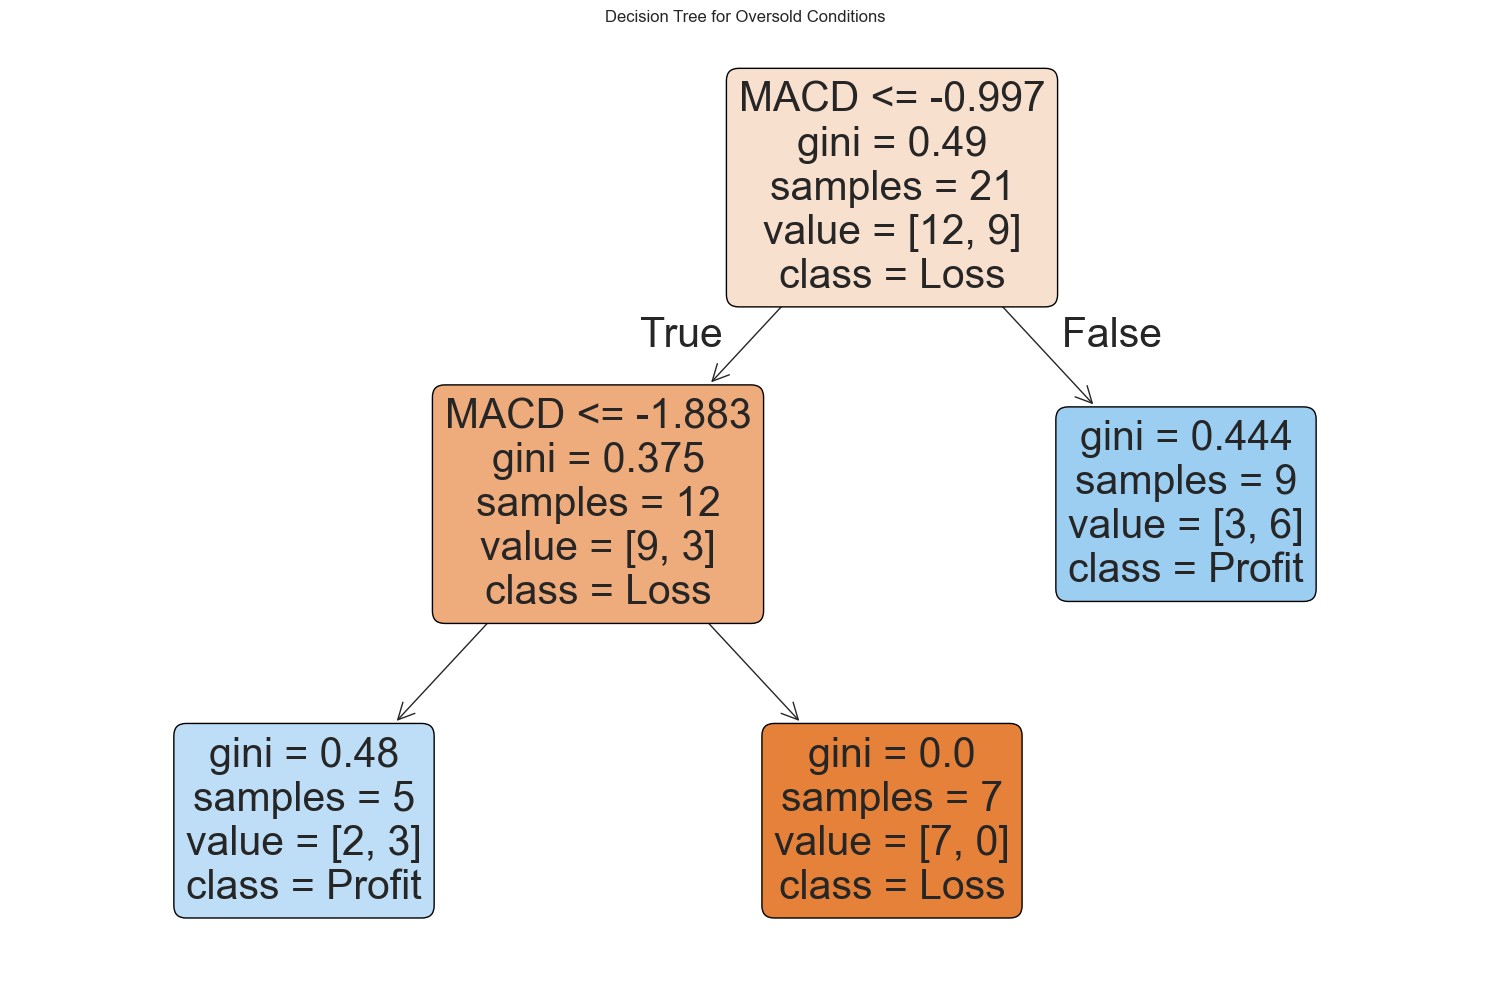

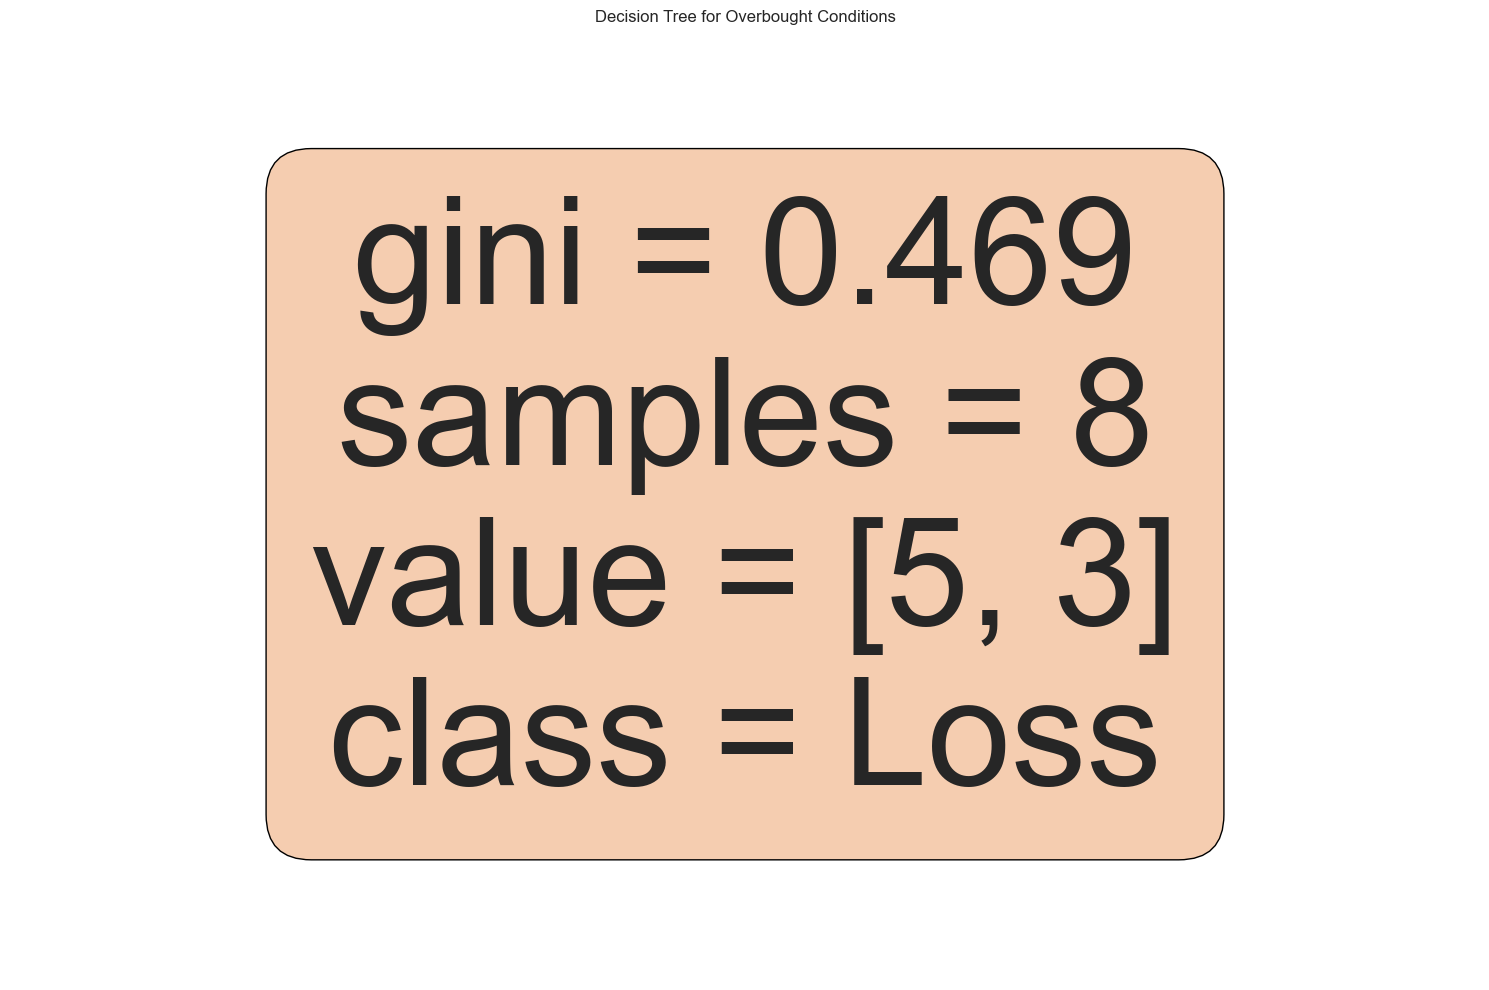

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler

def analyze_macd_confirmation(df):
    """
    Analyze potential MACD-based confirmation signals for trade switching.
    """
    # Create success flag (1 for profitable trades)
    df['Success'] = (df['Total P/L'] > 0).astype(int)
    
    # Create categorical variables for indicator conditions
    df['MACD_Direction'] = np.where(df['MACD'] > 0, 'Positive', 'Negative')
    df['MACD_Signal_Cross'] = np.where(df['MACD'] > df['MACD_signal'], 'Above', 'Below')
    df['MACD_Hist_Direction'] = np.where(df['MACD_hist'] > 0, 'Positive', 'Negative')
    df['MACD_Hist_ROC_Direction'] = np.where(df['MACD_hist_roc'] > 0, 'Increasing', 'Decreasing')
    
    # Separate analyses for overbought and oversold conditions
    df['RSI_Condition'] = pd.cut(df['RSI'], 
                                bins=[0, 30, 70, 100],
                                labels=['Oversold', 'Neutral', 'Overbought'])
    
    # Calculate success rates for different indicator combinations
    conditions = ['MACD_Direction', 'MACD_Signal_Cross', 'MACD_Hist_Direction', 'MACD_Hist_ROC_Direction']
    
    results = []
    for condition in conditions:
        for rsi_zone in ['Oversold', 'Overbought']:
            mask = df['RSI_Condition'] == rsi_zone
            success_rates = df[mask].groupby([condition, 'Original_Type'])['Success'].agg(['count', 'mean'])
            success_rates = success_rates.round(4)
            for idx, row in success_rates.iterrows():
                results.append({
                    'RSI_Zone': rsi_zone,
                    'Condition': condition,
                    'Indicator_Value': idx[0],
                    'Trade_Type': idx[1],
                    'Count': row['count'],
                    'Win_Rate': row['mean'] * 100,
                    'Avg_ROE': df[mask & (df[condition] == idx[0]) & 
                                 (df['Original_Type'] == idx[1])]['ROE (P/L %)'].mean() * 100
                })
    
    results_df = pd.DataFrame(results)
    
    # Create combination analysis
    def get_indicator_state(row):
        return (f"MACD:{row['MACD_Direction']}, "
                f"Signal:{row['MACD_Signal_Cross']}, "
                f"Hist:{row['MACD_Hist_Direction']}, "
                f"ROC:{row['MACD_Hist_ROC_Direction']}")
    
    df['Indicator_State'] = df.apply(get_indicator_state, axis=1)
    
    # Analyze complex combinations
    complex_results = []
    for rsi_zone in ['Oversold', 'Overbought']:
        mask = df['RSI_Condition'] == rsi_zone
        for trade_type in df['Original_Type'].unique():
            type_mask = mask & (df['Original_Type'] == trade_type)
            states = df[type_mask].groupby('Indicator_State')['Success'].agg(['count', 'mean'])
            states = states[states['count'] >= 5]  # Filter for combinations with at least 5 trades
            states = states.sort_values('mean', ascending=False)
            
            for idx, row in states.iterrows():
                avg_roe = df[type_mask & (df['Indicator_State'] == idx)]['ROE (P/L %)'].mean() * 100
                complex_results.append({
                    'RSI_Zone': rsi_zone,
                    'Trade_Type': trade_type,
                    'Indicator_State': idx,
                    'Count': row['count'],
                    'Win_Rate': row['mean'] * 100,
                    'Avg_ROE': avg_roe
                })
    
    complex_results_df = pd.DataFrame(complex_results)
    print(complex_results_df)
    
    # Decision Tree Analysis
    X = df[['MACD', 'MACD_signal', 'MACD_hist', 'MACD_hist_roc', 'RSI', 'RSI_roc','is_res']]
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    
    # Separate models for overbought and oversold conditions
    for rsi_zone in ['Oversold', 'Overbought']:
        mask = df['RSI_Condition'] == rsi_zone
        if mask.sum() > 0:  # Only if we have data for this zone
            X_zone = X_scaled[mask]
            y_zone = df[mask]['Success']
            
            if len(np.unique(y_zone)) > 1:  # Need at least two classes
                dt = DecisionTreeClassifier(max_depth=3, min_samples_leaf=5)
                dt.fit(X_zone, y_zone)
                
                plt.figure(figsize=(15, 10))
                plot_tree(dt, feature_names=X.columns, class_names=['Loss', 'Profit'],
                         filled=True, rounded=True)
                plt.title(f'Decision Tree for {rsi_zone} Conditions')
                plt.tight_layout()
                
    return results_df, complex_results_df

# Print analysis insights
def print_macd_insights(results_df, complex_results_df):
    print("=== MACD Confirmation Signal Analysis ===\n")
    
    # Print best individual indicator conditions
    for rsi_zone in ['Oversold', 'Overbought']:
        print(f"\nBest Individual Indicators for {rsi_zone} Conditions:")
        zone_results = results_df[results_df['RSI_Zone'] == rsi_zone]
        for condition in zone_results['Condition'].unique():
            best_result = zone_results[zone_results['Condition'] == condition].nlargest(1, 'Win_Rate')
            print(f"\n{condition}:")
            print(f"Best combination: {best_result['Indicator_Value'].values[0]}")
            print(f"Win Rate: {best_result['Win_Rate'].values[0]:.1f}%")
            print(f"Avg ROE: {best_result['Avg_ROE'].values[0]:.2f}%")
            print(f"Sample Size: {best_result['Count'].values[0]}")
    
    # Print best combined conditions
    print("\n=== Best Combined Indicator States ===")
    print(complex_results_df)
    for rsi_zone in ['Oversold', 'Overbought']:
        print(f"\nTop 3 Combinations for {rsi_zone} Conditions:")
        zone_results = complex_results_df[complex_results_df['RSI_Zone'] == rsi_zone]
        top_results = zone_results.nlargest(3, 'Win_Rate')
        for _, row in top_results.iterrows():
            print(f"\nIndicator State: {row['Indicator_State']}")
            print(f"Win Rate: {row['Win_Rate']:.1f}%")
            print(f"Avg ROE: {row['Avg_ROE']:.2f}%")
            print(f"Sample Size: {row['Count']}")

    print("\n=== Recommendations ===")
    print("Consider using these confirmation signals when:")
    
    for rsi_zone in ['Oversold', 'Overbought']:
        best_combo = complex_results_df[
            complex_results_df['RSI_Zone'] == rsi_zone
        ].nlargest(1, 'Win_Rate')
        
        if not best_combo.empty:
            print(f"\nFor {rsi_zone} conditions:")
            print(f"- Wait for: {best_combo['Indicator_State'].values[0]}")
            print(f"- Expected Win Rate: {best_combo['Win_Rate'].values[0]:.1f}%")
            print(f"- Expected Avg ROE: {best_combo['Avg_ROE'].values[0]:.2f}%")

# Example usage:
results_df, complex_results_df = analyze_macd_confirmation(df)
print_macd_insights(results_df, complex_results_df)

In [ ]:
asdf

NameError: name 'asdf' is not defined

In [ ]:
# symbols = ['AAPL','INTC','JNJ','TSLA','MSFT','AMZN','ABBV']
# symbols = ['AAPL', 'MSFT', 'NVDA', 'TSLA', 'AMZN', 'JPM', 'GOOGL', 'META', 'XOM', 'CVX', 'UNH', 'PFE', 'KO', 'PG', 'BA', 'CAT']
# symbols = ['NVDA', 'JPM', 'GOOGL', 'META', 'XOM', 'CVX', 'UNH', 'PFE', 'KO', 'PG', 'BA', 'CAT']
symbols = ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'TSLA', 'JPM', 'BAC', 'META', 'T', 'VZ', 'XOM', 'CVX', 'JNJ', 'PFE', 'KO'] # test 7. generally high-liquidity from 2016 to present
# symbols = ['AAPL', 'MSFT', 'NVDA', 'INTC', 'AMZN', 'TSLA', 'DIS', 'JPM', 'BAC', 'GOOGL', 'META', 'XOM', 'CVX', 'JNJ', 'PFE', 'KO'] # test3,7. generally high-liquidity from 2016 to 2019

In [ ]:
trades_folder = 'test7/trades'
graphs_folder = 'test7/graphs'
xbp_folder = 'test7/xbp'

from IPython.utils import io
for s in symbols:
    touch_detection_params.symbol = s
    touch_detection_params.export_bars_path=f'bars/bars_{touch_detection_params.symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    
    # print(touch_detection_params.symbol)
    # print(touch_detection_params.export_bars_path)
    results_list = []
    
    # print(touch_detection_params)
    touch_detection_areas = calculate_touch_detection_area(touch_detection_params)
    # continue
    for i in tqdm(list(np.arange(0.5, 4.01, 0.5))):
        
        strategy_params.times_buying_power = i
        with io.capture_output() as captured:
            strategy = TradingStrategy(touch_detection_areas, strategy_params)
            
            if i == 1:
                strategy.export_trades_path=f'{trades_folder}/trades_{touch_detection_params.symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
                strategy.export_graph_path=f'{graphs_folder}/{start_date.split()[0]}_{end_date.split()[0]}/graph_{touch_detection_params.symbol}_{start_date.split()[0]}_{end_date.split()[0]}.png'
            
            balance, longs_executed, shorts_executed, balance_change, mean_plpc, win_mean_plpc, lose_mean_plpc, winrate, total_costs, \
                avg_transact, count_entry_adjust, count_entry_skip, count_exit_adjust, count_exit_skip, key_stats = \
                strategy.run_backtest()

        trades_executed = longs_executed + shorts_executed
        newrow = {
            'xBP': i,
            'net%': balance_change,
            'balance': balance,
            'cnt': trades_executed,
            # 'AvgPL%': mean_plpc,
            # 'winAvgPL%': win_mean_plpc,
            # 'loseAvgPL%': lose_mean_plpc,
            'WR%': winrate,
            'TotalCosts': total_costs,
            # 'avg transactions': avg_transact,
            'entryAdjust': count_entry_adjust,
            'entrySkip': count_entry_skip,
            'exitAdjust': count_exit_adjust,
            'exitSkip': count_exit_skip,
            **key_stats
        }
        results_list.append(newrow)

    results = pd.DataFrame(results_list)
    # Format specific columns if needed
    results['xBP'] = results['xBP'].map('{:.1f}'.format)
    results['balance'] = results['balance'].map('${:.4f}'.format)
    results['TotalCosts'] = results['TotalCosts'].map('${:.4f}'.format)

    # Format all float columns
    float_columns = results.select_dtypes(include=['float64']).columns
    results[float_columns] = results[float_columns].applymap('{:.4f}'.format)

    # Display the results
    # pd.set_option('display.max_columns', None)
    filename = f'{xbp_folder}/xbp_{touch_detection_params.symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    results.to_csv(filename,index=False)
    # results

In [ ]:
# symbols = ['AAPL', 'MSFT', 'NVDA', 'TSLA', 'AMZN', 'JPM', 'GOOGL', 'META', 'XOM', 'CVX', 'UNH', 'PFE', 'KO', 'PG', 'BA', 'CAT','INTC','JNJ','ABBV'] # test2

In [ ]:
results_combined = pd.DataFrame()
for s in symbols:
    fname = f'{xbp_folder}/xbp_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    results = pd.read_csv(fname)
    results['symbol'] = s
    first_column = results.pop('symbol') 
    results.insert(0, 'symbol', first_column) 
    results_combined = pd.concat([results_combined, results],ignore_index=True)
results_combined['WinMax'] = results_combined[['LwinMax', 'SwinMax']].max(axis=1)
results_combined['LoseMin'] = results_combined[['LloseMin', 'SloseMin']].max(axis=1)
pd.set_option('display.max_rows', results_combined.shape[0])
pd.set_option('display.max_columns', results_combined.shape[1])
results_combined.loc[results_combined.xBP.isin({1,4})].sort_values('net%',ascending=False)

In [ ]:
for s in symbols:
    fname = f'{xbp_folder}/xbp_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    results = pd.read_csv(fname)
    plt.plot(results.xBP.astype(float).to_list(), results.AllAvg.astype(float).to_list(), label=s)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

In [ ]:
for s in symbols:
    fname = f'{xbp_folder}/xbp_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    results = pd.read_csv(fname)
    plt.plot(results.xBP.astype(float).to_list(), results['net%'].astype(float).to_list(), label=s)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

In [ ]:
for s in symbols:
    fname = f'{xbp_folder}/xbp_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    results = pd.read_csv(fname)
    plt.plot(results.xBP.astype(float).to_list(), results['WR%'].astype(float).to_list(), label=s)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

In [ ]:
import zipfile
from zoneinfo import ZoneInfo
ny_tz = ZoneInfo("America/New_York")
symbols = ['AAPL', 'MSFT', 'NVDA', 'INTC', 'AMZN', 'TSLA', 'DIS', 'JPM', 'BAC', 'GOOGL', 'META', 'XOM', 'CVX', 'JNJ', 'PFE', 'KO']
start_date = "2017-01-01 00:00:00"
end_date =   "2018-01-01 00:00:00"

for s in symbols:
    fname = f'{trades_folder}/trades_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    trades = csv_to_trade_positions(fname)
    
    export_bars_path=f'bars/bars_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    zip_file_path = export_bars_path.replace('.csv', '.zip')

    csv_file = zipfile.ZipFile(zip_file_path, 'r').open(os.path.basename(export_bars_path))
    df = pd.read_csv(csv_file)
    df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True).dt.tz_convert(ny_tz)
    df.set_index(['symbol', 'timestamp'], inplace=True)
    fill_missing_data(df)
    print(f'Retrieved bars from {zip_file_path}')
    
    # plot_cumulative_pl_and_price(trades, df, None)
    
    export_graph_path=f'{graphs_folder}/{start_date.split()[0]}_{end_date.split()[0]}/graph_{s}_{start_date.split()[0]}_{end_date.split()[0]}.png'
    plot_cumulative_pl_and_price(trades, df, None, filename=export_graph_path)

In [ ]:
import zipfile
from zoneinfo import ZoneInfo
ny_tz = ZoneInfo("America/New_York")
symbols = ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'TSLA', 'JPM', 'BAC', 'META', 'T', 'VZ', 'XOM', 'CVX', 'JNJ', 'PFE', 'KO'] 
start_date = "2024-01-01 00:00:00"
end_date =   "2024-09-27 00:00:00"

for s in symbols:
    fname = f'{trades_folder}/trades_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    trades = csv_to_trade_positions(fname)
    
    export_bars_path=f'bars/bars_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    zip_file_path = export_bars_path.replace('.csv', '.zip')

    csv_file = zipfile.ZipFile(zip_file_path, 'r').open(os.path.basename(export_bars_path))
    df = pd.read_csv(csv_file)
    df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True).dt.tz_convert(ny_tz)
    df.set_index(['symbol', 'timestamp'], inplace=True)
    fill_missing_data(df)
    print(f'Retrieved bars from {zip_file_path}')
    
    # plot_cumulative_pl_and_price(trades, df, None)
    
    export_graph_path=f'{graphs_folder}/{start_date.split()[0]}_{end_date.split()[0]}/graph_{s}_{start_date.split()[0]}_{end_date.split()[0]}.png'
    plot_cumulative_pl_and_price(trades, df, None, filename=export_graph_path)